In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"
combined_dataset_folder = "datasets/combined_dataset"

INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

should_load_sisfall_data = False

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [3]:
if should_load_sisfall_data is True:
    raw_sisfall_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)

    raw_sisfall_dataset.to_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")
else:
    raw_sisfall_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [4]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files


uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity5','Activity6'])
# uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity13','Activity14','Activity15'])

raw_uma_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

raw_uma_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)


raw_uma_df

,TimeStamp,acc_x,acc_y,acc_z,Subject,Activity,Trial,Tag
0,0.130,1.007568,0.14209,0.352539,15,2,1,0
1,0.151,1.007568,0.14209,0.352539,15,2,1,0
2,0.179,1.010986,0.137451,0.344482,15,2,1,0
3,0.194,1.010986,0.137451,0.344482,15,2,1,0
4,0.215,0.9375,0.135498,0.400879,15,2,1,0
...,...,...,...,...,...,...,...,...
35675,14.825,-0.912598,-0.041504,0.334717,9,6,2,0
35676,14.847,-0.912842,-0.037109,0.334961,9,6,2,0
35677,14.864,-0.912842,-0.037109,0.334961,9,6,2,0
35678,14.906,-0.91748,-0.038574,0.341797,9,6,2,0


In [5]:
grouped_data = []


combined_df_sorted = raw_uma_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                # 'group_id': group_id,
                'data': sensor_data,
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'data': sensor_data,
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())


if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'data': sensor_data,
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_raw_dataset = pd.DataFrame(grouped_data)
uma_raw_dataset['activity'].value_counts()


activity
D1    55
D2    28
D5    19
D6    19
Name: count, dtype: int64

In [6]:
uma_raw_dataset['data'][0]

,acc_x,acc_y,acc_z
0,-0.740234,0.571289,0.249512
1,-0.842285,0.598145,0.297119
2,-0.833252,0.425781,0.332031
3,-0.721191,0.518311,0.116455
4,-0.741699,0.651611,0.380127
...,...,...,...
280,-0.878662,0.503418,0.118896
281,-0.760742,0.463623,0.170898
282,-0.702393,0.350342,0.258301
283,-0.600098,0.412842,0.168457


In [7]:
UMA_ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02', 'D1'],  
    'jogging': ['D03', 'D04', 'D2'],
    # 'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11", "F12", "F13", "F14", "F15", 'D13', 'D14', 'D15'],
    'stairs': ["D5", "D6"]
}

# Create a function to map activity codes to class names
def map_activity_to_class(activity_code):
    for class_name, codes in UMA_ACTIVITY_CLASSES.items():
        if activity_code in codes:
            return class_name
    return 'unknown'

# Apply the mapping function to update the activity column
uma_raw_dataset['activity'] = uma_raw_dataset['activity'].apply(lambda x: f"D{x}" if isinstance(x, int) else x)
uma_raw_dataset['activity'] = uma_raw_dataset['activity'].apply(map_activity_to_class)

In [8]:
uma_raw_dataset['activity'].value_counts()

activity
walking    55
stairs     38
jogging    28
Name: count, dtype: int64

In [9]:
uma_raw_dataset.drop(columns=['subject', 'trial'], inplace=True)

In [10]:
uma_raw_dataset

,activity,data
0,walking,acc_x acc_y acc_z 0 -0.74023...
1,walking,acc_x acc_y acc_z 0 -0.76416...
2,walking,acc_x acc_y acc_z 0 -0.75732...
3,walking,acc_x acc_y acc_z 0 -0.95336...
4,walking,acc_x acc_y acc_z 0 -0.96289...
...,...,...
116,walking,acc_x acc_y acc_z 0 -0.89990...
117,walking,acc_x acc_y acc_z 0 -0.98339...
118,jogging,acc_x acc_y acc_z 0 -0.94531...
119,jogging,acc_x acc_y acc_z 0 -0.92138...


In [11]:
import itertools
import numpy as np
import pandas as pd



def extract_features(data, with_magnitude):
    data = data.copy()
    # Clean and ensure all data is numeric
    for col in data.columns:
        data[col] = data[col].astype(str)
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.fillna(0)


    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")

        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0   


    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:   
                slice_ = data.iloc[:, i:i+3]
                magnitude = np.linalg.norm(slice_, axis=1)
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                data[name] = magnitude


    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))


    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))


    features = pd.DataFrame([features], columns=columns)
    return features


feature_list = []
labels = []
activity_codes = []

prepared_uma_dataset = uma_raw_dataset.copy()


for i in prepared_uma_dataset.index:
    data = prepared_uma_dataset['data'][i]

    features_uma = extract_features(data, True)

    feature_list.append(features_uma)
    activity_codes.append(prepared_uma_dataset['activity'][i])

# Combine into final dataset
prepared_uma_dataset = pd.concat(feature_list, ignore_index=True)

prepared_uma_dataset['class'] = activity_codes


In [12]:
prepared_uma_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,0.620804,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824,walking
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,1.390414,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870,walking
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,0.583319,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498,walking
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,1.716752,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053,walking
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,2.868545,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-0.898072,-0.487766,0.072545,1.067387,0.080598,0.065205,0.029794,0.085993,0.283898,0.255353,...,1.601228,-1.081055,-0.657837,-0.040710,0.881005,-0.673584,-0.265137,0.151062,1.244717,walking
117,-0.854187,-0.463067,-0.046990,1.052171,0.102395,0.054107,0.077899,0.073612,0.319992,0.232609,...,1.689971,-1.061523,-0.570679,-0.139404,0.832011,-0.654419,-0.308594,0.131226,1.205085,walking
118,-0.213790,-0.993080,-0.182802,1.640629,0.656342,2.021341,0.331128,1.382479,0.810150,1.421739,...,4.967511,-0.752197,-1.617188,-0.377197,0.904716,0.506836,0.160522,0.161377,1.902402,jogging
119,-0.414322,-1.069628,-0.247166,1.791346,0.709144,2.630337,0.479860,1.987280,0.842107,1.621831,...,7.298552,-0.952393,-2.080566,-0.332520,0.890076,0.282715,0.052979,0.080566,2.220238,jogging


In [13]:
SISFALL_ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02'],  
    'jogging': ['D03', 'D04'],
    # 'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11", "F12", "F13", "F14", "F15"],
    'stairs': ['D05','D06', 'D5','D6'],
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in SISFALL_ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name

CODE_TO_CLASS

{'D01': 'walking',
 'D02': 'walking',
 'D03': 'jogging',
 'D04': 'jogging',
 'D05': 'stairs',
 'D06': 'stairs',
 'D5': 'stairs',
 'D6': 'stairs'}

In [14]:
def prepare_sisfall_dataset(raw_dataset, CODE_TO_CLASS, duration, frequency):
    filtered_indices = []
    for i in raw_dataset.index:
        activity_code = raw_dataset['activity'][i]
        if activity_code in CODE_TO_CLASS:
            filtered_indices.append(i)
    
    feature_list = []
    labels = []
    subjects = []
    activity_codes = []

    for i in filtered_indices:
        data = raw_dataset['data'][i]
        activity_code = raw_dataset['activity'][i]
        data = change_activity_duration(data, duration)

        # data = change_activity_sampling(data, frequency)
        
        # Extract features (now includes the new accelerometer features)
        features = extract_features(data, with_magnitude=True)
        
        # Get class label
        class_label = CODE_TO_CLASS[activity_code]
        
        # Store results
        feature_list.append(features)
        labels.append(class_label)
        subjects.append(raw_dataset['subject'][i])
        activity_codes.append(activity_code)

    # Combine into final dataset
    prepared_dataset = pd.concat(feature_list, ignore_index=True)
    prepared_dataset['class'] = labels
    prepared_dataset['subject'] = subjects

    print(f"Final dataset shape: {prepared_dataset.shape}")
    print(f"Number of new accelerometer features added: 14")
    print("\nClass distribution:")
    print(prepared_dataset['class'].value_counts())
    
    return prepared_dataset
prepared_sisfall_dataset = prepare_sisfall_dataset(raw_sisfall_dataset, CODE_TO_CLASS, duration, frequency)


Final dataset shape: (1058, 38)
Number of new accelerometer features added: 14

Class distribution:
class
walking    380
jogging    370
stairs     308
Name: count, dtype: int64


In [15]:
prepared_sisfall_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,subject
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking,SA01
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking,SA01
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking,SA01
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking,SA01
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking,SA01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,-0.050304,-0.831797,-0.531665,1.010431,0.017650,0.017212,0.024080,0.015056,0.132852,0.131196,...,-0.128906,-0.906250,-0.648438,0.933138,0.039062,-0.722656,-0.417969,1.034437,stairs,SE15
1054,-0.057461,-0.848906,-0.504344,1.009761,0.016946,0.017762,0.024473,0.017870,0.130176,0.133273,...,-0.148438,-0.910156,-0.597656,0.933007,0.023438,-0.773438,-0.386719,1.033670,stairs,SE15
1055,-0.040410,-0.851758,-0.500846,1.006632,0.014972,0.014511,0.019875,0.014022,0.122360,0.120462,...,-0.105469,-0.914062,-0.593750,0.941153,0.027344,-0.769531,-0.410156,1.028600,stairs,SE15
1056,-0.062992,-0.847684,-0.513423,1.010200,0.013965,0.011516,0.019549,0.010665,0.118174,0.107312,...,-0.140625,-0.910156,-0.585938,0.943958,0.015625,-0.773438,-0.441406,1.035027,stairs,SE15


In [16]:
prepared_sisfall_dataset = prepared_sisfall_dataset.drop(columns=['subject'])

In [17]:
prepared_uma_dataset 

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,0.620804,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824,walking
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,1.390414,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870,walking
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,0.583319,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498,walking
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,1.716752,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053,walking
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,2.868545,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-0.898072,-0.487766,0.072545,1.067387,0.080598,0.065205,0.029794,0.085993,0.283898,0.255353,...,1.601228,-1.081055,-0.657837,-0.040710,0.881005,-0.673584,-0.265137,0.151062,1.244717,walking
117,-0.854187,-0.463067,-0.046990,1.052171,0.102395,0.054107,0.077899,0.073612,0.319992,0.232609,...,1.689971,-1.061523,-0.570679,-0.139404,0.832011,-0.654419,-0.308594,0.131226,1.205085,walking
118,-0.213790,-0.993080,-0.182802,1.640629,0.656342,2.021341,0.331128,1.382479,0.810150,1.421739,...,4.967511,-0.752197,-1.617188,-0.377197,0.904716,0.506836,0.160522,0.161377,1.902402,jogging
119,-0.414322,-1.069628,-0.247166,1.791346,0.709144,2.630337,0.479860,1.987280,0.842107,1.621831,...,7.298552,-0.952393,-2.080566,-0.332520,0.890076,0.282715,0.052979,0.080566,2.220238,jogging


In [18]:
prepared_sisfall_dataset['class'].value_counts()

class
walking    380
jogging    370
stairs     308
Name: count, dtype: int64

In [19]:
prepared_uma_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,0.620804,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824,walking
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,1.390414,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870,walking
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,0.583319,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498,walking
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,1.716752,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053,walking
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,2.868545,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-0.898072,-0.487766,0.072545,1.067387,0.080598,0.065205,0.029794,0.085993,0.283898,0.255353,...,1.601228,-1.081055,-0.657837,-0.040710,0.881005,-0.673584,-0.265137,0.151062,1.244717,walking
117,-0.854187,-0.463067,-0.046990,1.052171,0.102395,0.054107,0.077899,0.073612,0.319992,0.232609,...,1.689971,-1.061523,-0.570679,-0.139404,0.832011,-0.654419,-0.308594,0.131226,1.205085,walking
118,-0.213790,-0.993080,-0.182802,1.640629,0.656342,2.021341,0.331128,1.382479,0.810150,1.421739,...,4.967511,-0.752197,-1.617188,-0.377197,0.904716,0.506836,0.160522,0.161377,1.902402,jogging
119,-0.414322,-1.069628,-0.247166,1.791346,0.709144,2.630337,0.479860,1.987280,0.842107,1.621831,...,7.298552,-0.952393,-2.080566,-0.332520,0.890076,0.282715,0.052979,0.080566,2.220238,jogging


In [20]:
final_combined_dataset = pd.concat([prepared_sisfall_dataset, prepared_uma_dataset], ignore_index=True)

final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,-0.898072,-0.487766,0.072545,1.067387,0.080598,0.065205,0.029794,0.085993,0.283898,0.255353,...,1.601228,-1.081055,-0.657837,-0.040710,0.881005,-0.673584,-0.265137,0.151062,1.244717,walking
1175,-0.854187,-0.463067,-0.046990,1.052171,0.102395,0.054107,0.077899,0.073612,0.319992,0.232609,...,1.689971,-1.061523,-0.570679,-0.139404,0.832011,-0.654419,-0.308594,0.131226,1.205085,walking
1176,-0.213790,-0.993080,-0.182802,1.640629,0.656342,2.021341,0.331128,1.382479,0.810150,1.421739,...,4.967511,-0.752197,-1.617188,-0.377197,0.904716,0.506836,0.160522,0.161377,1.902402,jogging
1177,-0.414322,-1.069628,-0.247166,1.791346,0.709144,2.630337,0.479860,1.987280,0.842107,1.621831,...,7.298552,-0.952393,-2.080566,-0.332520,0.890076,0.282715,0.052979,0.080566,2.220238,jogging


In [21]:
import os
import pandas as pd
import numpy as np

# earpiece_classes = ['walking', 'jogging','fall']
earpiece_classes = ['walking', 'jogging','stairs']

# read earpiece data from datasets/earpiece from *.csv files
earpiece_folder = "datasets/earpiece/"
earpiece_data = []

# Search for all CSV files in the earpiece folder
for filename in os.listdir(earpiece_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(earpiece_folder, filename)
        
        # Extract activity class from filename
        for activity in earpiece_classes:
            if activity in filename:
                class_name = activity
                break
        else:
            continue  # Skip files that don't match any activity class
        
        # Read data
        df = pd.read_csv(file_path)
        
        # Process accelerometer data
        if 'X' in df.columns and 'Y' in df.columns and 'Z' in df.columns:
            # Rename columns to match the format used in other datasets
            sensor_data = df[['X', 'Y', 'Z']].copy()
            sensor_data.columns = ['acc_y', 'acc_x', 'acc_z']
            
            # Create a record for this activity
            earpiece_data.append({
            'class': class_name,
            'data': sensor_data,
            })
        else:
            print(f"Warning: File {filename} does not contain X, Y, Z accelerometer columns")

# Convert to DataFrame
earpiece_raw_dataset = pd.DataFrame(earpiece_data)
earpiece_raw_dataset
# Extract features from the data
# feature_list = []
data_list = []
activity_labels = []

for i in earpiece_raw_dataset.index:
    data = earpiece_raw_dataset['data'][i]
    data = change_activity_duration(data, duration)
    features = extract_features(data, True)

    # activity_labels.append(earpiece_raw_dataset['activity'][i])

In [22]:
final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,-0.898072,-0.487766,0.072545,1.067387,0.080598,0.065205,0.029794,0.085993,0.283898,0.255353,...,1.601228,-1.081055,-0.657837,-0.040710,0.881005,-0.673584,-0.265137,0.151062,1.244717,walking
1175,-0.854187,-0.463067,-0.046990,1.052171,0.102395,0.054107,0.077899,0.073612,0.319992,0.232609,...,1.689971,-1.061523,-0.570679,-0.139404,0.832011,-0.654419,-0.308594,0.131226,1.205085,walking
1176,-0.213790,-0.993080,-0.182802,1.640629,0.656342,2.021341,0.331128,1.382479,0.810150,1.421739,...,4.967511,-0.752197,-1.617188,-0.377197,0.904716,0.506836,0.160522,0.161377,1.902402,jogging
1177,-0.414322,-1.069628,-0.247166,1.791346,0.709144,2.630337,0.479860,1.987280,0.842107,1.621831,...,7.298552,-0.952393,-2.080566,-0.332520,0.890076,0.282715,0.052979,0.080566,2.220238,jogging


In [23]:
final_combined_dataset['class'].value_counts()

class
walking    435
jogging    398
stairs     346
Name: count, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test = train_test_split(final_combined_dataset, 
    test_size=0.2, 
    stratify=final_combined_dataset['class'], 
    random_state=42
)

y_train = X_train['class']
y_test = X_test['class']

final_X_train = X_train.drop(columns=['class'])
final_X_test = X_test.drop(columns=['class'])



In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(final_X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(final_X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(final_X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(final_X_train, y_train)


lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(final_X_train, y_train)


lda = LinearDiscriminantAnalysis()
lda.fit(final_X_train, y_train)


mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(final_X_train, y_train)

if should_save_models:
    joblib.dump(svm, f"{models_output_folder}/svm_model_combined_adl.pkl")
    joblib.dump(rf, f"{models_output_folder}/rf_model_combined_adl.pkl")
    joblib.dump(knn, f"{models_output_folder}/knn_model_combined_adl.pkl")
    joblib.dump(dt, f"{models_output_folder}/dt_model_combined_adl.pkl")
    joblib.dump(lr, f"{models_output_folder}/lr_model_combined_adl.pkl")
    joblib.dump(lda, f"{models_output_folder}/lda_model_combined_adl.pkl")
    joblib.dump(mlp, f"{models_output_folder}/mlp_model_combined_adl.pkl")


Model: SVC
Classification Report:
              precision    recall  f1-score   support

     jogging       0.99      0.97      0.98        80
      stairs       1.00      0.94      0.97        69
     walking       0.93      0.99      0.96        87

    accuracy                           0.97       236
   macro avg       0.97      0.97      0.97       236
weighted avg       0.97      0.97      0.97       236

Confusion Matrix:
Accuracy: 0.9703



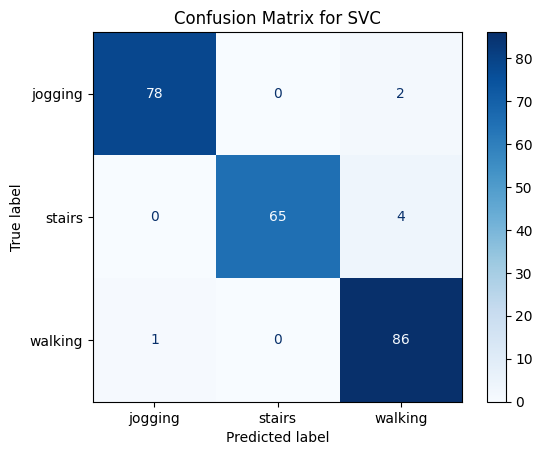

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

     jogging       1.00      0.99      0.99        80
      stairs       0.99      1.00      0.99        69
     walking       0.99      0.99      0.99        87

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236

Confusion Matrix:
Accuracy: 0.9915



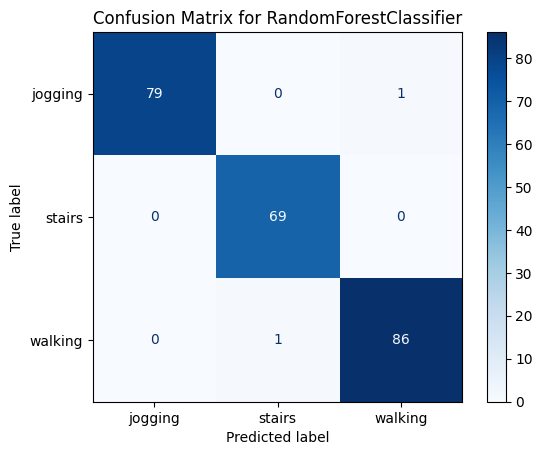

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

     jogging       0.97      0.95      0.96        80
      stairs       0.88      0.91      0.89        69
     walking       0.91      0.90      0.90        87

    accuracy                           0.92       236
   macro avg       0.92      0.92      0.92       236
weighted avg       0.92      0.92      0.92       236

Confusion Matrix:
Accuracy: 0.9195



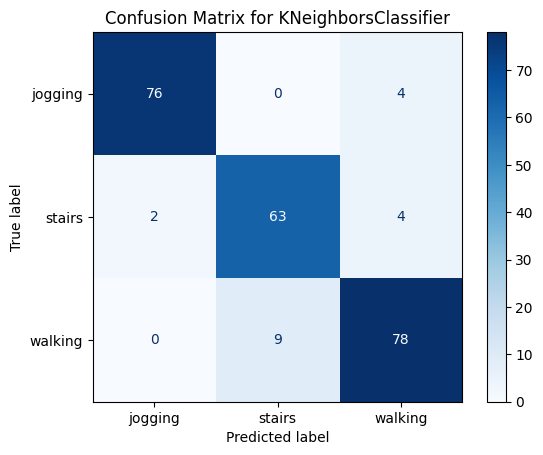

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

     jogging       0.98      0.99      0.98        80
      stairs       0.91      0.97      0.94        69
     walking       0.96      0.90      0.93        87

    accuracy                           0.95       236
   macro avg       0.95      0.95      0.95       236
weighted avg       0.95      0.95      0.95       236

Confusion Matrix:
Accuracy: 0.9492



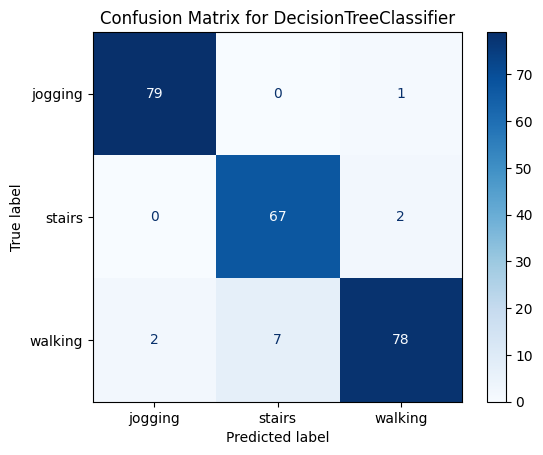

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

     jogging       0.99      0.99      0.99        80
      stairs       0.96      0.96      0.96        69
     walking       0.95      0.95      0.95        87

    accuracy                           0.97       236
   macro avg       0.97      0.97      0.97       236
weighted avg       0.97      0.97      0.97       236

Confusion Matrix:
Accuracy: 0.9661



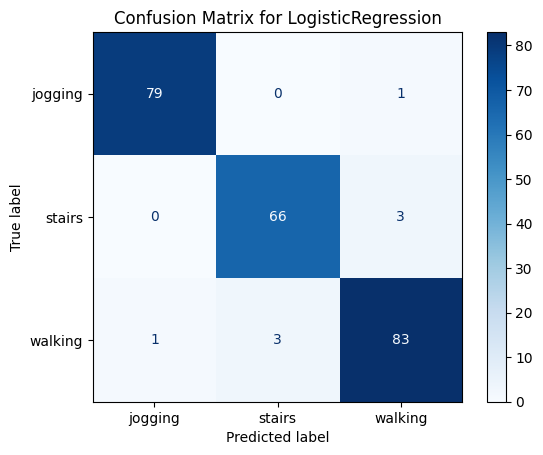

Model: MLPClassifier
Classification Report:
              precision    recall  f1-score   support

     jogging       1.00      0.99      0.99        80
      stairs       0.99      0.99      0.99        69
     walking       0.98      0.99      0.98        87

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236

Confusion Matrix:
Accuracy: 0.9873



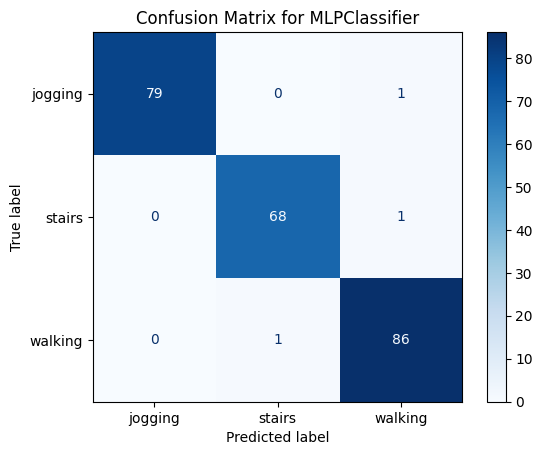

Model: LinearDiscriminantAnalysis
Classification Report:
              precision    recall  f1-score   support

     jogging       1.00      0.94      0.97        80
      stairs       0.95      0.87      0.91        69
     walking       0.86      0.97      0.91        87

    accuracy                           0.93       236
   macro avg       0.94      0.92      0.93       236
weighted avg       0.93      0.93      0.93       236

Confusion Matrix:
Accuracy: 0.9280



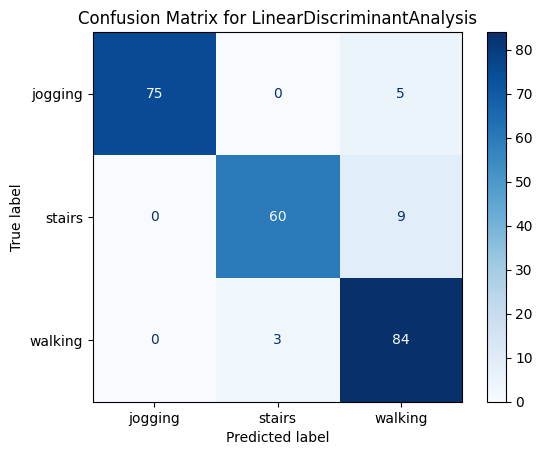

In [26]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, final_X_test, y_test)
evaluate_model(rf, final_X_test, y_test)
evaluate_model(knn, final_X_test, y_test)
evaluate_model(dt, final_X_test, y_test)
evaluate_model(lr, final_X_test, y_test)
evaluate_model(mlp, final_X_test, y_test)
evaluate_model(lda, final_X_test, y_test)

In [27]:
# First, let's properly prepare the earpiece dataset
feature_list = []
class_labels = []

for i in earpiece_raw_dataset.index:
    data = earpiece_raw_dataset['data'][i]
    features = extract_features(data, True)
    feature_list.append(features)
    class_labels.append(earpiece_raw_dataset['class'][i])

prepared_earpiece_dataset = pd.concat(feature_list, ignore_index=True)


required_columns = final_X_train.columns


for col in required_columns:
    if col not in prepared_earpiece_dataset.columns:
        prepared_earpiece_dataset[col] = 0


prepared_earpiece_dataset = prepared_earpiece_dataset[required_columns]

print(f"Prepared earpiece dataset shape: {prepared_earpiece_dataset.shape}")
print(f"Training data shape: {final_X_train.shape}")
prepared_earpiece_dataset


Prepared earpiece dataset shape: (18, 36)
Training data shape: (943, 36)


,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,0.546556,-0.814437,-0.133941,1.012872,0.018413,0.012891,0.026289,0.011655,0.135695,0.113540,...,1.161133,1.217528,0.452148,-0.884277,-0.250977,0.951735,0.639648,-0.744629,-0.023926,1.053523
1,0.130228,-0.981495,0.081754,1.019077,0.034700,0.116514,0.026035,0.125707,0.186278,0.341342,...,1.472168,2.738534,0.010742,-1.203979,-0.026367,0.755763,0.225586,-0.727661,0.197266,1.250041
2,0.596157,-0.583608,-0.490585,1.010749,0.046796,0.070467,0.043037,0.075362,0.216323,0.265456,...,1.699219,2.114208,0.434570,-0.762207,-0.623047,0.759017,0.743164,-0.403320,-0.348633,1.208641
3,0.126547,-0.892698,0.332406,1.020349,0.074712,0.039711,0.050111,0.046841,0.273336,0.199277,...,1.550293,2.297987,-0.049316,-0.980469,0.189453,0.879827,0.306152,-0.765137,0.476074,1.119072
4,0.097580,-0.976068,-0.052473,1.021467,0.047016,0.114432,0.035501,0.118538,0.216832,0.338278,...,1.557617,2.693815,-0.039062,-1.182739,-0.165161,0.752464,0.235962,-0.713379,0.071289,1.226112
5,0.372957,-0.912954,-0.074060,1.015826,0.031527,0.038684,0.027877,0.044252,0.177557,0.196684,...,0.941406,1.195542,0.257935,-1.029175,-0.181396,0.854349,0.476074,-0.766602,0.043335,1.121241
6,0.530408,-0.632372,-0.497541,1.014100,0.052813,0.080119,0.061828,0.095134,0.229812,0.283052,...,1.795410,1.702119,0.355347,-0.825806,-0.646240,0.721878,0.689575,-0.411133,-0.345703,1.240125
7,0.391926,0.187115,-0.874793,1.001327,0.018197,0.030326,0.008908,0.008656,0.134896,0.174144,...,1.141602,1.268497,0.328979,0.104980,-0.904297,0.978043,0.429199,0.284668,-0.830933,1.011279
8,0.125751,-0.913790,0.377383,1.021575,0.031060,0.103376,0.045554,0.129619,0.176240,0.321522,...,1.309082,1.887539,0.011719,-1.077637,0.245117,0.747116,0.235229,-0.654297,0.476562,1.214726
9,0.096793,-0.881041,0.391017,1.021225,0.049937,0.048110,0.060186,0.053828,0.223465,0.219339,...,1.869141,2.179278,-0.056641,-1.006348,0.219727,0.858749,0.257324,-0.729980,0.550293,1.144253


In [28]:
class_labels

['walking',
 'stairs',
 'walking',
 'walking',
 'stairs',
 'stairs',
 'walking',
 'walking',
 'stairs',
 'stairs',
 'walking',
 'walking',
 'stairs',
 'stairs',
 'jogging',
 'jogging',
 'jogging',
 'stairs']

In [29]:
y_train

53       stairs
921     walking
209      stairs
418      stairs
1051    jogging
         ...   
207      stairs
621      stairs
85       stairs
513     walking
498     jogging
Name: class, Length: 943, dtype: object

SVM Accuracy: 0.3889
              precision    recall  f1-score   support

     jogging       1.00      0.33      0.50         3
      stairs       0.45      0.62      0.53         8
     walking       0.17      0.14      0.15         7

    accuracy                           0.39        18
   macro avg       0.54      0.37      0.39        18
weighted avg       0.43      0.39      0.38        18


Random Forest Accuracy: 0.2778
              precision    recall  f1-score   support

     jogging       0.60      1.00      0.75         3
      stairs       0.00      0.00      0.00         8
     walking       0.25      0.29      0.27         7

    accuracy                           0.28        18
   macro avg       0.28      0.43      0.34        18
weighted avg       0.20      0.28      0.23        18


KNN Accuracy: 0.6667
              precision    recall  f1-score   support

     jogging       1.00      0.67      0.80         3
      stairs       0.71      0.62      0.67         8


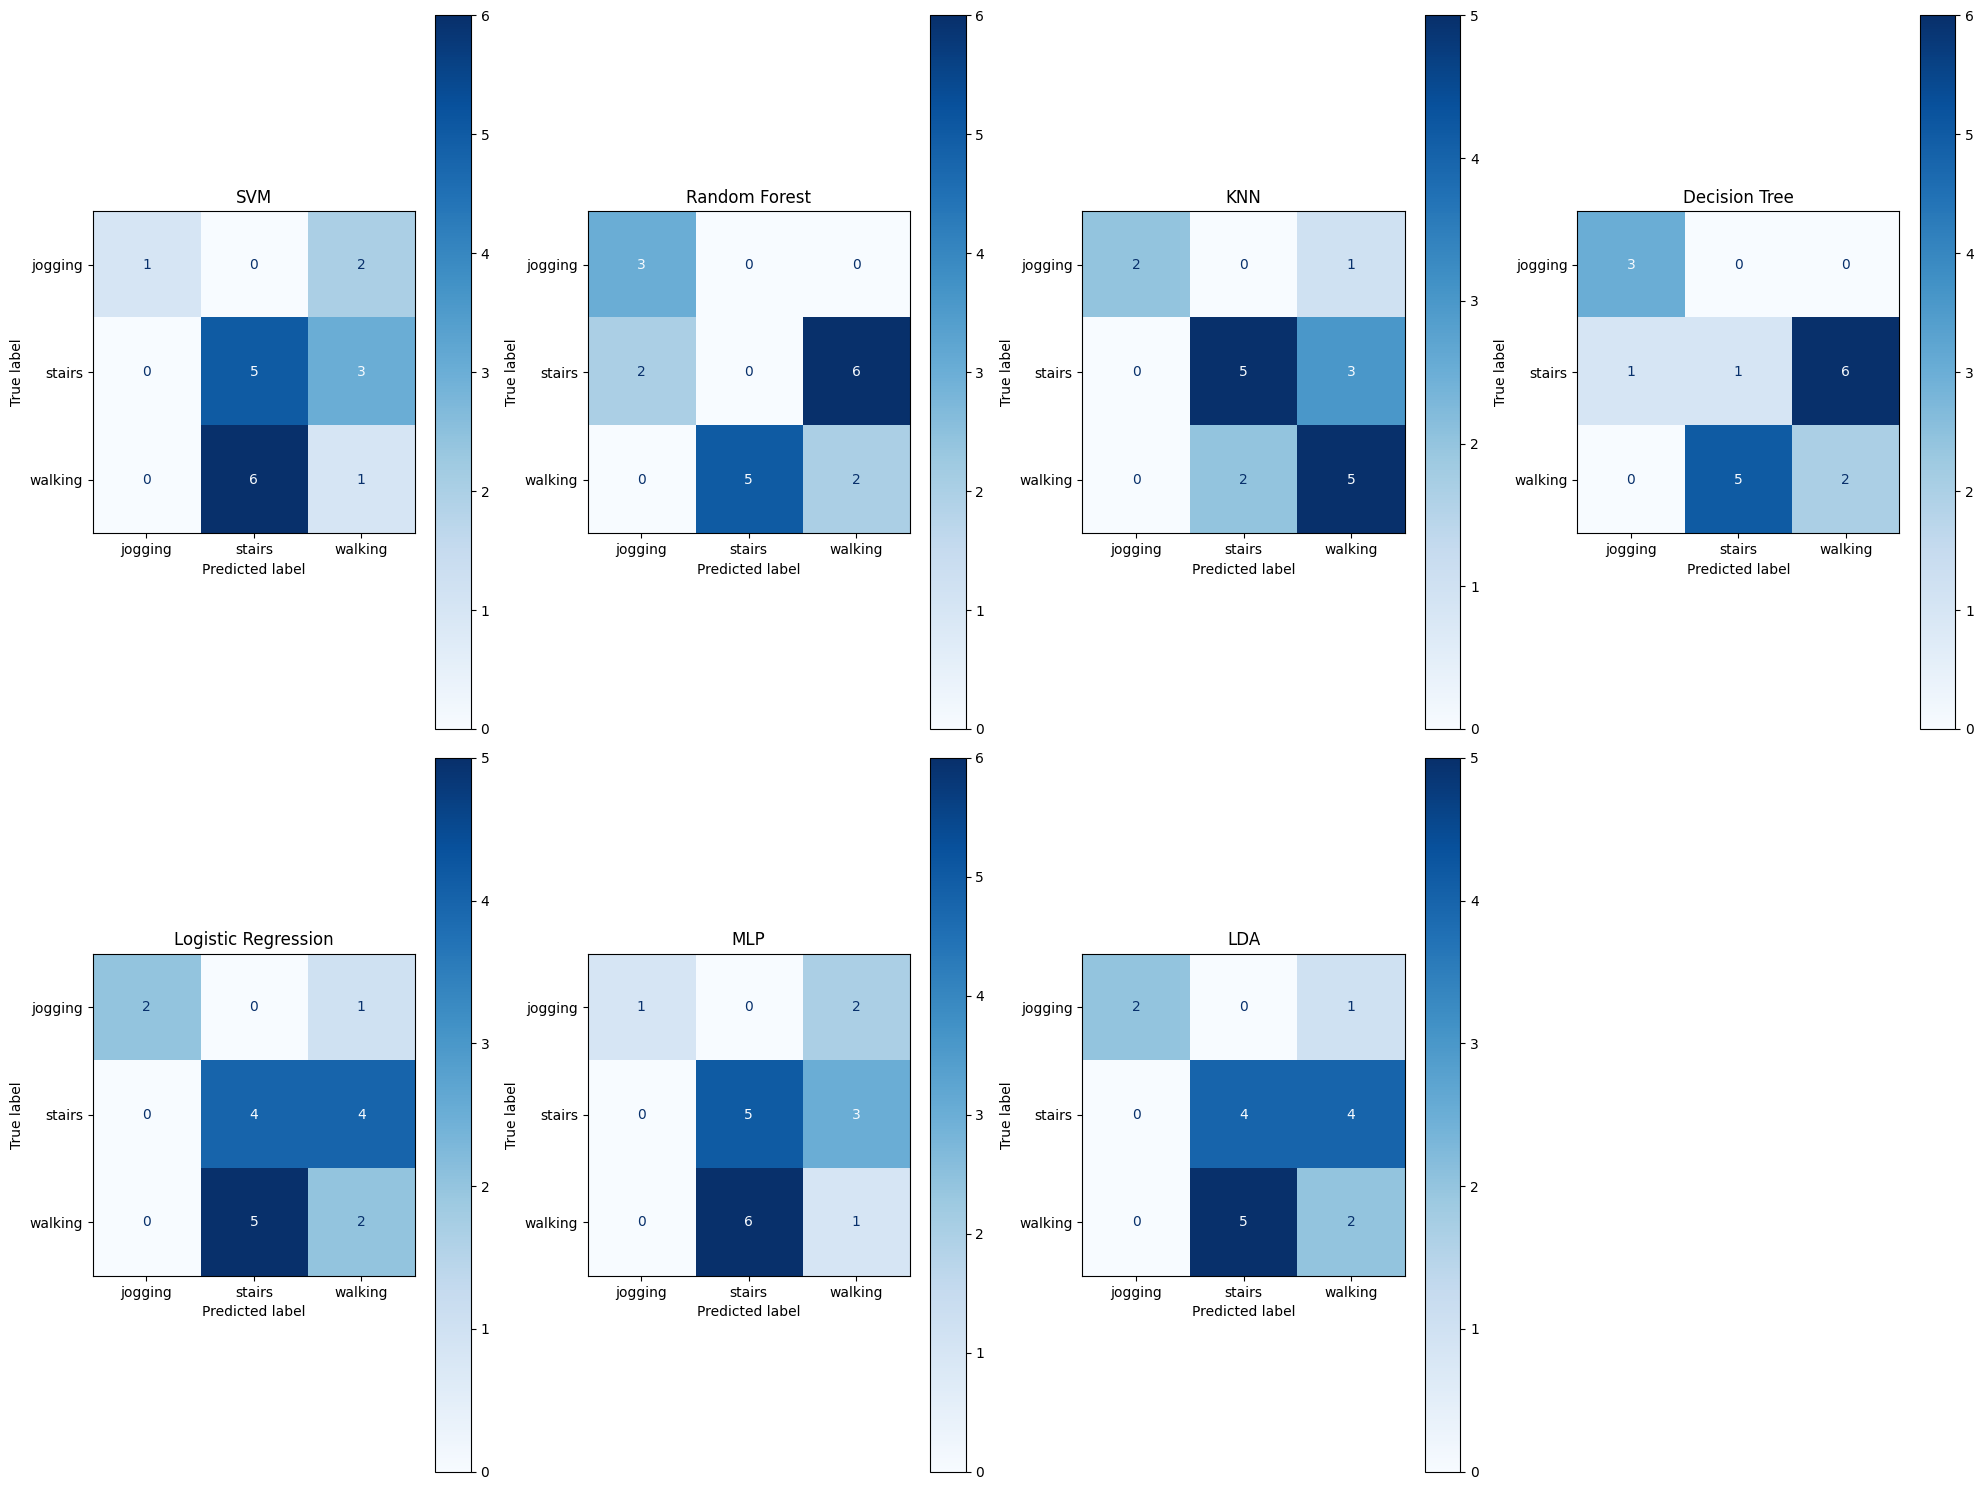

In [31]:
# Make predictions using the trained models
svm_pred = svm.predict(prepared_earpiece_dataset)
rf_pred = rf.predict(prepared_earpiece_dataset)
knn_pred = knn.predict(prepared_earpiece_dataset)
dt_pred = dt.predict(prepared_earpiece_dataset)
lr_pred = lr.predict(prepared_earpiece_dataset)
mlp_pred = mlp.predict(prepared_earpiece_dataset)
lda_pred = lda.predict(prepared_earpiece_dataset)

# Print accuracy and classification report for each model
print(f"SVM Accuracy: {accuracy_score(class_labels, svm_pred):.4f}")
print(classification_report(class_labels, svm_pred))
print()

print(f"Random Forest Accuracy: {accuracy_score(class_labels, rf_pred):.4f}")
print(classification_report(class_labels, rf_pred))
print()

print(f"KNN Accuracy: {accuracy_score(class_labels, knn_pred):.4f}")
print(classification_report(class_labels, knn_pred))
print()

print(f"Decision Tree Accuracy: {accuracy_score(class_labels, dt_pred):.4f}")
print(classification_report(class_labels, dt_pred))
print()

print(f"Logistic Regression Accuracy: {accuracy_score(class_labels, lr_pred):.4f}")
print(classification_report(class_labels, lr_pred))
print()

print(f"MLP Accuracy: {accuracy_score(class_labels, mlp_pred):.4f}")
print(classification_report(class_labels, mlp_pred))
print()

print(f"LDA Accuracy: {accuracy_score(class_labels, lda_pred):.4f}")
print(classification_report(class_labels, lda_pred))
print()

# Create confusion matrices
# Ensure the labels are consistent
unique_labels = np.unique(np.concatenate([np.unique(class_labels), np.unique(y_train)]))

plt.figure(figsize=(20, 15))

plt.subplot(2, 4, 1)
cm = confusion_matrix(class_labels, svm_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("SVM")

plt.subplot(2, 4, 2)
cm = confusion_matrix(class_labels, rf_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Random Forest")

plt.subplot(2, 4, 3)
cm = confusion_matrix(class_labels, knn_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("KNN")

plt.subplot(2, 4, 4)
cm = confusion_matrix(class_labels, dt_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Decision Tree")

plt.subplot(2, 4, 5)
cm = confusion_matrix(class_labels, lr_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Logistic Regression")

plt.subplot(2, 4, 6)
cm = confusion_matrix(class_labels, mlp_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("MLP")

plt.subplot(2, 4, 7)
cm = confusion_matrix(class_labels, lda_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("LDA")

plt.tight_layout()
plt.show()
